# 1. Import and path configuration part

In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from PIL import Image,ImageFile
import copy
import matplotlib.pyplot as plt
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, Activation
from keras import Sequential
from keras.metrics import CategoricalCrossentropy, Accuracy
from tensorflow import convert_to_tensor

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from sam_utils import *
from models import *
from utils import *

In [3]:
datapath = "../data/msdi/"
os.chdir(datapath)

In [4]:
!ls

deep_features  labels.csv  metadata_msdi.csv  msdi_mapping.csv
img	       lyrics	   mfcc		      README.md


# 2. Load the data references



In [5]:
msdi = get_msdi_dataframe("") # all the references of our data

In [6]:
msdi.head(2)

,Unnamed: 0,msd_track_id,genre,album_index,set,msd_artist_id,image_url,img,mfcc,deep_features
0,0,TRABKJU128F422A7FE,Metal,0,train,ARBD4QW1187FB42153,http://artwork-cdn.7static.com/static/img/slee...,img/0000848744_200.jpg,mfcc/mfcc_A.npz,0
1,1,TRBLDQQ128F92E58B4,Rock,1,train,AR3RK011187FB3CE3B,http://artwork-cdn.7static.com/static/img/slee...,img/0000476534_200.jpg,mfcc/mfcc_B.npz,1


# 3. Image subsampling comparison

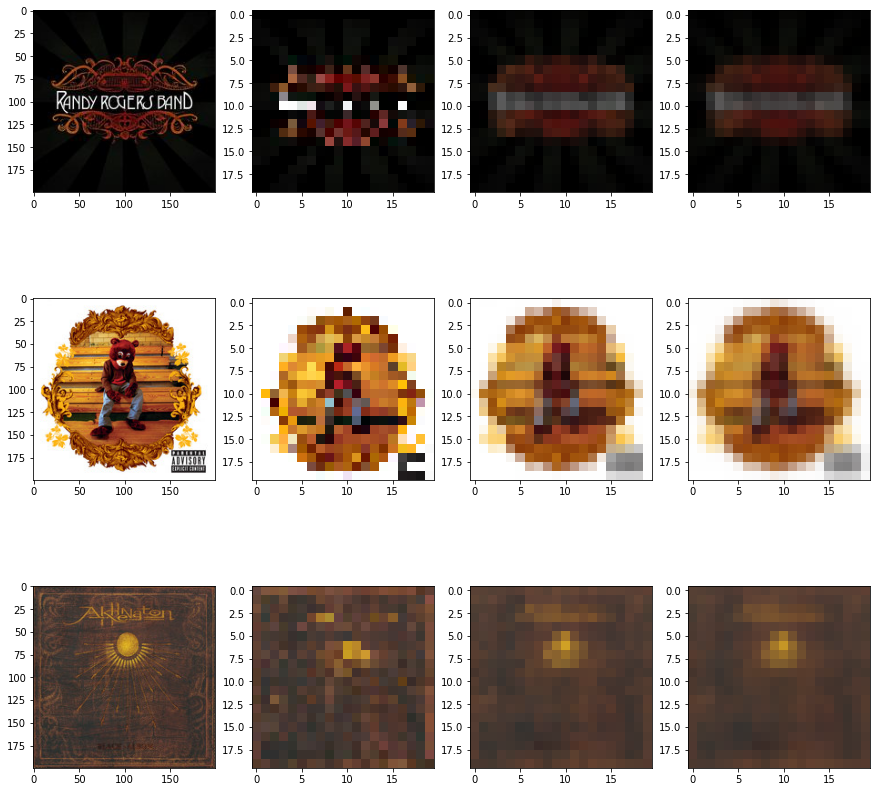

In [7]:
# compare our 3 sampling methods for multiple images (see utils.py file for more details)
raw_data = {}
naive_sampling_data = {}
average_sampling_data = {}
clean_sampling_data = {}
key_list = []
n=10

for k in [random.randint(0, len(msdi)-1) for i in range(3)]: # shuffle to get another set of image
    #array = data.get(k)
    array = load_img(entry = msdi.iloc[k], msdi_path="")
    raw_data[k] = array
    naive_sampling_data[k] = naive_sampling(array, n)
    average_sampling_data[k] = average_sampling(array, n)
    clean_sampling_data[k] = clean_sampling(array, n)

    key_list.append(k)

fig, axes = plt.subplots(len(key_list), 4, figsize=(15,15))

for i in range(len(key_list)):
    k = key_list[i]
    axes[i][0].imshow(raw_data[k]) # raw image
    axes[i][1].imshow(naive_sampling_data[k]) # naively sampled image
    axes[i][2].imshow(average_sampling_data[k]) # averagesampled image
    axes[i][3].imshow(clean_sampling_data[k]) # cleanly sampled image

# we see that the naive sampling has a high variance. Some small elements can constiture 1 element of the picture, and thus lead to a lot of dropped information.
# Average sampling helps more to distinguish part of the images, and averages the colors in each portion of the image.
# Average sampling and clean sampling methods are quite equivalent in term of results (but still clean sampling is better in term of details)

# 4. HOG feature comparison

In [ ]:
# compare our the hog features for different parameters
hog4 = {}
hog8 = {}
hog16 = {}
raw_img = {}
key_list = []

for k in [random.randint(0, len(msdi)-1) for i in range(3)]: # shuffle to get another set of image
    array = load_img(entry = msdi.iloc[k], msdi_path="")
    raw_img[k] = array
    hog4[k] = compute_hog(array, 4)
    hog8[k] = compute_hog(array, 8)
    hog16[k] = compute_hog(array, 16)
    key_list.append(k)

fig, axes = plt.subplots(len(key_list), 4, figsize=(20,20))

for i in range(len(key_list)):
    k = key_list[i]
    axes[i][0].imshow(raw_img[k]) # raw image
    axes[i][1].imshow(hog16[k]) # 16 hog image
    axes[i][2].imshow(hog8[k]) # 8 hog image
    axes[i][3].imshow(hog4[k]) # 4 hog image

# with hog=4 we loose a lot of information (the geometric aspect of the image is a bit lost in non rectangular areas), but not so much from switching from 8 to 16. It would be interesting to see the impact on the prediction results.

# 5. Image classifier with SGDClassifier

## 1. Data formatting

In [7]:
labels = msdi.genre.values
ref = msdi.msd_track_id.values
data = msdi.iloc[:5000].apply(preprocess_image_vectorized, axis=1) # preprocess (load the images, compute the features)
labels = labels[:5000]
ref = ref[:5000]

Y, classes, y_dict = one_hot_encode(labels)

In [33]:
array.shape

(200, 200, 3)

In [13]:
print(len(Counter(labels)), Counter(labels)) # number of labels & repartition of the labels

15 Counter({'Rock': 2235, 'Electronic': 520, 'Pop': 357, 'Rap': 333, 'Metal': 282, 'Jazz': 274, 'Reggae': 196, 'Country': 183, 'RnB': 180, 'Folk': 135, 'Blues': 91, 'Punk': 85, 'Latin': 59, 'World': 46, 'New Age': 24})


In [14]:
X = np.array(list(data.values))

In [16]:
print(X.shape,Y.shape)

(5000, 13, 13, 3) (5000, 15, 1)


In [17]:
#normalize our data (X will take its values in [0,1] interval)

normalize = False

if normalize:
    X = X.astype(np.float16) # cast to signed int

    for i in range(X.shape[0]):
        X[i] = X[i]/255
        if i in [10,100,1000,10000]:
            print(i)

## 2. Simplistic model : 3x3 array, logistic regression

In [18]:
clf = SGDClassifier()

In [35]:
data.iloc[-1]

In [19]:
#train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(len(X),-1), classes, test_size=0.2)

# train classifier
clf.fit(X_train, Y_train)

SGDClassifier()

In [20]:
#predict on the test set
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_pred, Y_test))

0.383


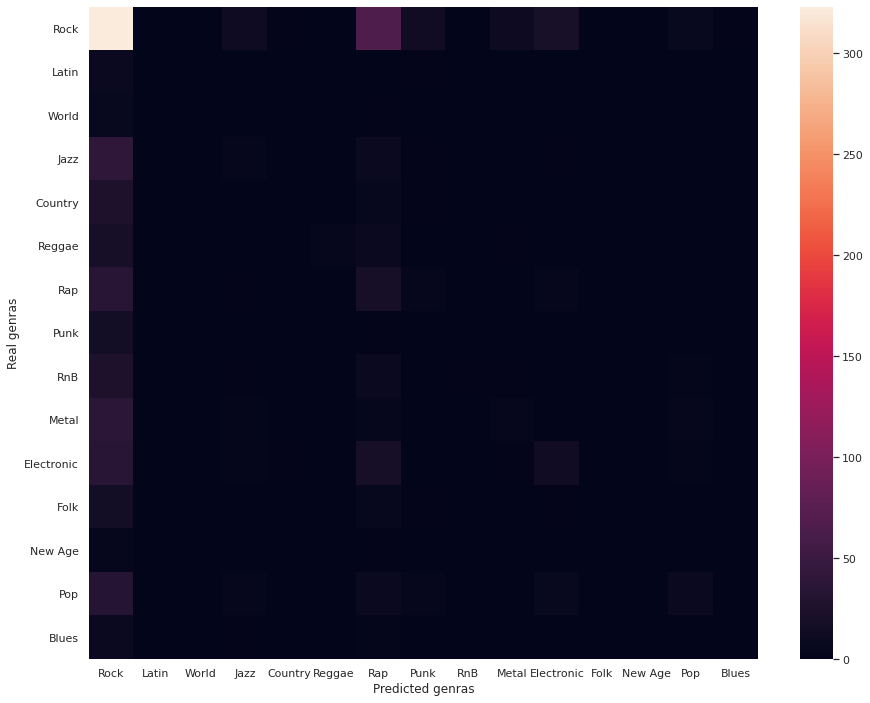

In [21]:
# plot the confusion matrix
plot_confusion(Y_test,Y_pred, y_dict)

# We see that the most predicted labels by the classifier are 'electronic' and 'world'. Other labels are not so often predicted

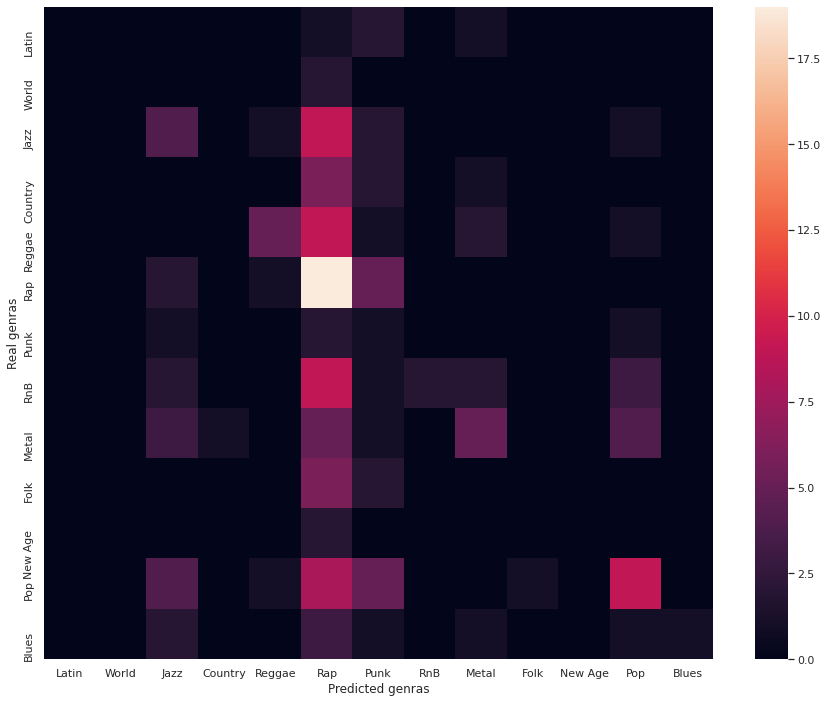

In [22]:
keep = list(y_dict.keys())
keep.remove("Rock")
keep.remove("Electronic")
plot_confusion(Y_test,Y_pred, y_dict, keep)

#we see that, appart from our 2 most present classes (Rock and Electronic), our images get classified very randomly
# The confusion matrix of the ideal classifier should be a diagonal matrix, and the confusion matrix we get by removing "Rock" and "Electronic" genras are far from this ideal

# 6. Image classifier with CNN

In [7]:
#load raw data

labels = msdi.genre.values
ref = msdi.msd_track_id.values
Y, classes, y_dict = one_hot_encode(labels)

data = msdi.apply(lambda row: preprocess_image_vectorized(row,sampling="raw"),axis=1) # preprocess (load the images, compute the features)


In [8]:
X = np.array(list(data.values))

In [9]:
print(X.shape, Y.shape)

(30712, 200, 200, 3) (30712, 15, 1)


In [10]:
# Train/Test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
del X # useful since X_train and X_test take additionnal space (which is valuable for the fitting of our model)

In [11]:
class_weight = compute_class_weight(classes)
print(class_weight)
weight_tensor = convert_to_tensor(list(class_weight.values()))

{0: 1.991975544516622, 1: 1.0, 2: 3.0682754561506766, 3: 1.9517034818420065, 4: 9.478181818181818, 5: 4.556818181818182, 6: 1.085815455113518, 7: 1.520268299795859, 8: 2.8393246187363834, 9: 1.949513836948392, 10: 10.488933601609657, 11: 2.9319460067491563, 12: 7.3113604488078545, 13: 6.318787878787879, 14: 19.671698113207547}


In [12]:
model = image_model(input_shape=X_train.shape[1:])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 30)      2280      
_________________________________________________________________
activation (Activation)      (None, 196, 196, 30)      0         
_________________________________________________________________
dropout (Dropout)            (None, 196, 196, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 193, 193, 20)      9620      
_________________________________________________________________
activation_1 (Activation)    (None, 193, 193, 20)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 193, 193, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 191, 191, 15)      2

In [14]:
model.fit(X_train, Y_train, epochs=10) #train our CNN

Epoch 1/10
141/768 [====>.........................] - ETA: 43:38 - loss: 2.7609 - accuracy: 0.8738

KeyboardInterrupt: 

In [102]:
Y_pred = model.predict(X_test) #predict on new data
Y_pred = np.array([np.argmax(elem) for elem in Y_pred])

In [103]:
Y_real = Y_test.reshape(3358,15)
Y_real = np.array([np.argmax(elem) for elem in Y_real])

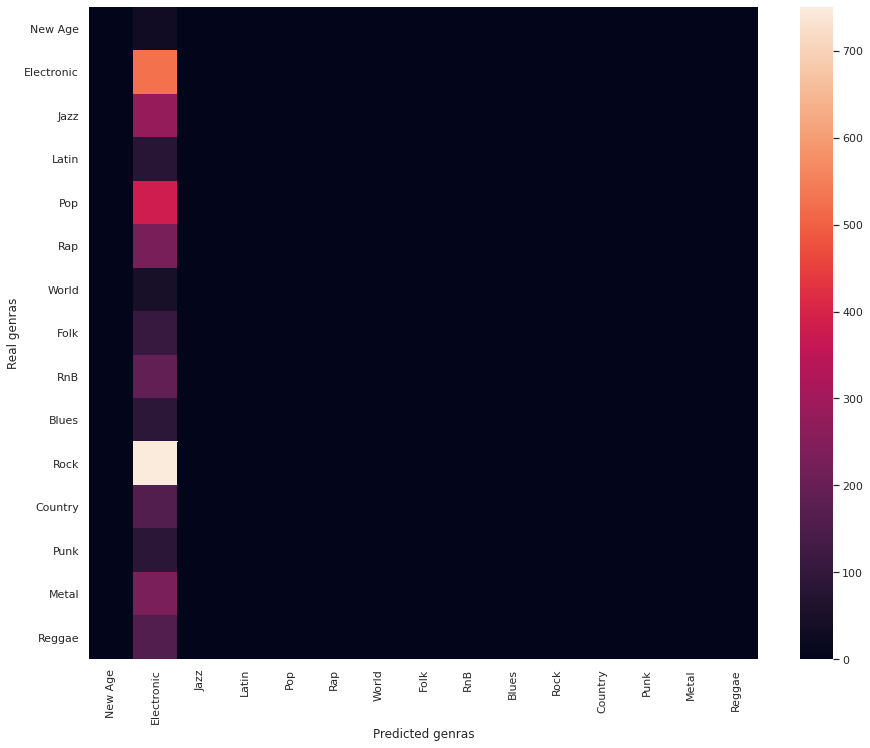

In [104]:
plot_confusion(Y_real, Y_pred, y_dict)

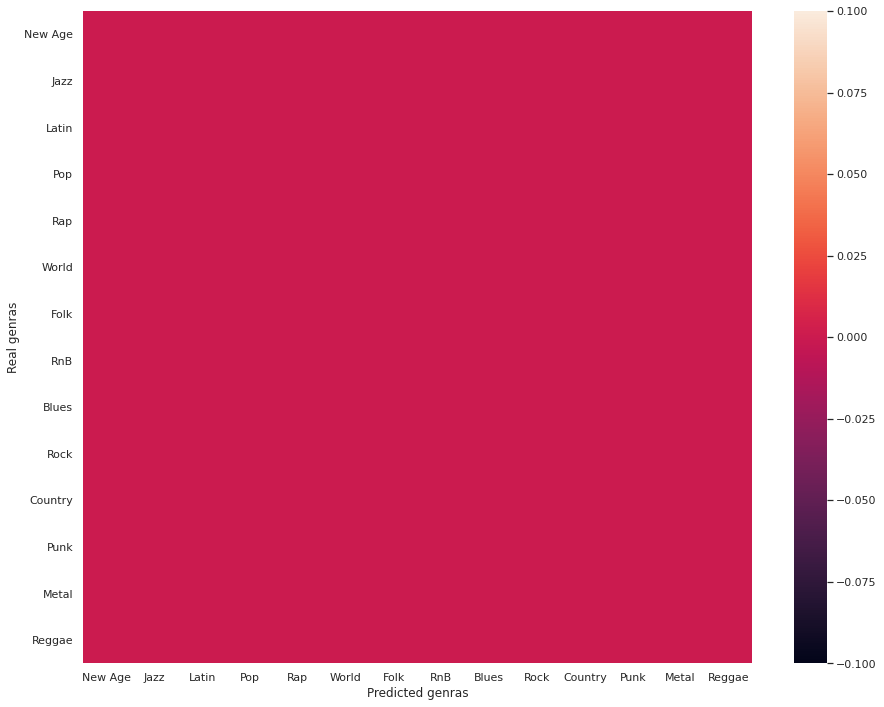

In [106]:
keep = list(y_dict.keys())
#keep.remove("Rock")
keep.remove("Electronic")
plot_confusion(Y_real,Y_pred, y_dict, keep)